In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import nrrd
import seaborn as sns
from typing import List

In [2]:
# I/O

# Data directory
data = os.path.abspath('./data')

# 1. Data loading

## 1.1. Getting list of DICOM files from folder

In [3]:
# Retrieving dcm filenames from data folder 

def dicom_list(data_dir: str) -> List[str]: 
    '''Locate all .dcm files in directory'''
    dicoms = []
    for dirs, subdirs, filenames in os.walk(data_dir):
        
        for filename in filenames:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                dicoms.append(os.path.join(data_dir, filename))
    
    return sorted(dicoms)

In [5]:
dcms = dicom_list(data)

In [6]:
# Length of our dataset
len(dcms)

140

## 1.2. Loading DICOMs as `np.ndarray`

In [4]:
def dcm_as_np(dicom_list: List[str]) -> np.ndarray:
    
    ref_dcm = pydicom.read_file(dicom_list[0])

    # Load dimensions based on the number of rows & columns
    dims = (int(ref_dcm.Rows), int(ref_dcm.Columns),len(dicom_list))
    
    dcm_array = np.zeros(dims, dtype=ref_dcm.pixel_array.dtype)
    
    for filename in dicom_list:
        # read the file
        ds = pydicom.read_file(filename)
        # store the raw image data
        dcm_array[:, :, dicom_list.index(filename)] = ds.pixel_array
    
    return dcm_array

In [7]:
dcm_array = dcm_as_np(dcms)

In [8]:
type(dcm_array)

numpy.ndarray

In [9]:
dcm_array.shape

(512, 512, 140)

## 1.3. Loading `nrrd` masks

In [10]:
def nrrd_list(data_dir: str, region: str) -> List[str]:
    '''Locate referenced .nrrd files in directory'''
    nrrd_list = []
    for dirs, subdirs, filenames in os.walk(data_dir):
        
        for filename in filenames:
            if region in filename.lower():  # check whether the file's DICOM
                nrrd_list.append(os.path.join(data_dir, filename))
    
    return sorted(nrrd_list)

def load_nrrd(nrrd_list: List[str]) -> np.ndarray:
    
    ref_nrrd, header = nrrd.read(nrrd_list[0])

    # Load dimensions based on the number of rows & columns
    dims = (ref_nrrd.shape[0], ref_nrrd.shape[1], len(nrrd_list))
    nrrd_array = np.zeros(dims)
    
    for filename in nrrd_list:
        data, header = nrrd.read(filename)
        nrrd_array[:, :, nrrd_list.index(filename)] = data.T
    
    return nrrd_array

In [141]:
mask['region 0'] = load_nrrd(nrrd_list(data, 'region 0'))

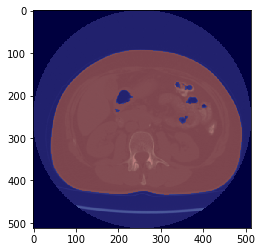

In [142]:
plt.imshow(dcm_array[:,:,0], cmap=plt.cm.bone, interpolation='nearest')
plt.imshow(mask['region 0'][:, :, 0], cmap='jet', alpha=0.5, interpolation='nearest');

To get **background mask** we need to **invert region 0** - *all tissues* mask

In [143]:
mask = {}

for n in range(0, 5): 
    reg = 'region ' + str(n)
    matrix = load_nrrd(nrrd_list(data, reg))
    if n == 0:
        mask[reg] = np.logical_not(matrix)
    else:
        matrix[matrix > 0] = n + 1
        mask[reg] = matrix

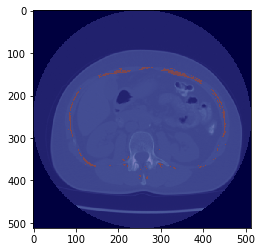

In [144]:
plt.imshow(dcm_array[:,:,0], cmap=plt.cm.bone, interpolation='none')
plt.imshow(mask['region 2'][:, :, 0],  cmap='jet', alpha=0.5, interpolation='none');

In [128]:
masks_uni = np.array(list(mask.values()), dtype=np.int32)

In [129]:
masks_uni.shape

(5, 512, 512, 140)

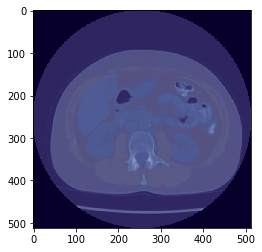

In [136]:
plt.imshow(dcm_array[:,:,0], cmap=plt.cm.bone, interpolation='none')
for n in range(0, 5):
    plt.imshow(masks_uni[n, :, :, 0],  cmap='jet', alpha=0.1, interpolation='none');

# 2. Data preprocessing
## 2.1. Normalization

In [27]:
def mean_normalize(x: np.array) -> np.array:
    '''Mean normalization for array'''
    return (x - np.mean(x)) / np.std(x)

def min_max(x: np.array) -> np.array:
    '''Min max normalization for array'''
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [28]:
dcm_norm, dcm_min_max = mean_normalize(dcm_array), min_max(dcm_array)

### Comparing different techniques visually

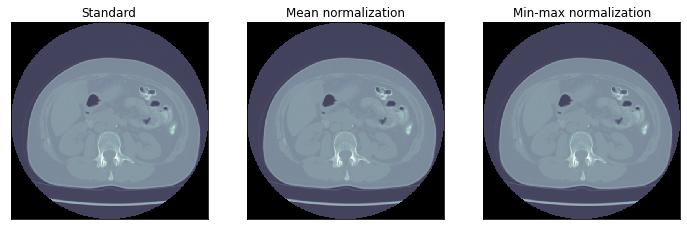

In [25]:
dcms = [dcm_array, dcm_norm, dcm_min_max]
methods = ['Standard', 'Mean normalization', 'Min-max normalization']
fig, axes = plt.subplots(1,3, figsize=(12,18))
for ax, m, dcm in zip(axes, methods, dcms): 
    
    ax.imshow(dcm[:,:,0], cmap=plt.cm.bone, interpolation='none')
    
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    
    ax.set_title(m)

### Comparing mean and min-max normalization

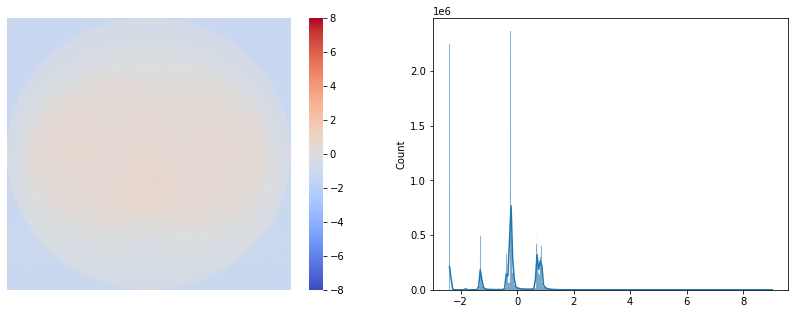

In [71]:
diff = dcm_norm - dcm_min_max
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(np.mean(diff, axis=2), ax=axes[0], cmap='coolwarm', vmin=-8, vmax=8)
axes[0].set_xticks([]) 
axes[0].set_yticks([])
sns.histplot(diff.flat, kde=True, ax=axes[1]);